In [17]:
import sys
sys.path.append('../code/functions')
from connectLib import otsuVox
from connectLib import clusterThresh
from plosLib import pipeline as PLOS
from random import randrange as rand
from cluster import Cluster
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
def neighborhoodDensity(data, interPlane = 1, intraPlane = 1, percentile = 50):
    output = np.zeros_like(data)
    for z in range(data.shape[0]):
        for y in range(data.shape[1]):
            for x in range(data.shape[2]):
                zLow = z-intraPlane
                zHigh = z+intraPlane
                yLow = y-interPlane
                yHigh = y+interPlane
                xLow = x-interPlane
                xHigh = x+interPlane
                if zLow>=0 and zHigh<data.shape[0] and yLow>=0 and yHigh<data.shape[1] and xLow>=0 and xHigh<data.shape[2]:
                    subVol = data[zLow:zHigh, yLow:yHigh, xLow:xHigh]
                    if not all(subVol.shape) == 0:
                        thresh = np.percentile(subVol, percentile)
                        binSubVol = subVol >= thresh
                        output[z][y][x] = (np.count_nonzero(binSubVol)/float(interPlane*interPlane*intraPlane)) * data[z][y][x] * np.average(subVol)
    return output

In [3]:
def generatePointSet():
    center = (rand(0, 9), rand(0, 999), rand(0, 999))
    toPopulate = []
    for z in range(-3, 2):
        for y in range(-3, 2):
            for x in range(-3, 2):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 1000:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((10, 1000, 1000))
    myPointSet = set()
    for _ in range(rand(1000, 2000)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = rand(40000, 60000)
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    toPop = rand(0, 10)
                    if toPop == 5:
                        noiseVolume[z][y][x] = rand(0, 60000)
    return volume, noiseVolume

In [4]:
def f1score(trueClusterList, testClusterList):
    
    tp = 0
    fp = 0
    fn = 0
    
    testClusterTuples = []
    for elem in testClusterList:
        myTupleList = []
        members = elem.members
        for member in members:
            myTupleList.append(tuple(member))
        testClusterTuples.append(myTupleList)

    trueClusterTuples = []
    for elem in trueClusterList:
        myTupleList = []
        members = elem.members
        for member in members:
            myTupleList.append(tuple(member))
        trueClusterTuples.append(myTupleList)
    
    truePositives = []
    for testList in testClusterTuples:
        found = False
        for trueList in trueClusterTuples:
            if len(set(testList).intersection(set(trueList))) > 0:
                found = True
        if found:
            truePositives.append(testList)
            tp+=1
    
    fp = len(testClusterList) - tp
    fn = len(trueClusterList) - tp
    precision = float(tp)/float(fp+tp)
    recall = float(tp)/float(tp+fn)
    f1 = (2*precision*recall)/(precision+recall)
    
    return precision, recall, f1, truePositives, trueClusterTuples, testClusterTuples

In [5]:
statListP = []
statListN = []

def executeRealisticSim():
    testVol, noiseVol = generateTestVolume()
    
    realSimN = neighborhoodDensity(noiseVol, 2, 2, 50)
    realSimNB = otsuVox(realSimN)
    realSimP = PLOS(noiseVol, 1, 1)
    realSimPB = otsuVox(realSimP)
    
    clustersN = clusterThresh(realSimNB[4:6])
    clustersP = clusterThresh(realSimPB[4:6])
    clustersT = clusterThresh(testVol[4:6])
    
    precisionN, recallN, f1N, _, _, _ = f1score(clustersT, clustersN)
    precisionP, recallP, f1P, _, _, _ = f1score(clustersT, clustersP)
    
    print 'Neighborhood:'
    print '\tPrecision: ', precisionN
    print '\tRecall: ', recallN
    print '\tf1: ', f1N

    print 'PLOS:'
    print '\tPrecision: ', precisionP
    print '\tRecall: ', recallP
    print '\tf1: ', f1P
    
    statListN.append([precisionN, recallN, f1N])
    statListP.append([precisionP, recallP, f1P])

In [ ]:
def toDiff(imgA, imgB):
    ret = np.empty((imgA.shape[0], imgA.shape[1], 3), dtype=np.uint8)
    for y in range(imgA.shape[0]):
        for x in range(imgA.shape[1]):
            
            if imgA[y][x] and not imgB[y][x]:
                ret[y][x][0] = 255
                ret[y][x][1] = 0
                ret[y][x][2] = 0
            elif not imgA[y][x] and imgB[y][x]:
                ret[y][x][0] = 0
                ret[y][x][1] = 255
                ret[y][x][2] = 0
            elif imgA[y][x] and imgB[y][x]:
                ret[y][x][0] = 255
                ret[y][x][1] = 255
                ret[y][x][2] = 0
            else:
                ret[y][x][0] = 255
                ret[y][x][1] = 255
                ret[y][x][2] = 255
            
    return ret

def visDiff(sliceA, sliceB):
    disp = toDiff(sliceA, sliceB)
    return disp

In [6]:
executeRealisticSim()

Neighborhood:
	Precision:  0.490970654628
	Recall:  0.984162895928
	f1:  0.655120481928
PLOS:
	Precision:  1.0
	Recall:  0.684389140271
	f1:  0.812625923439


In [9]:
testVol, noiseVol = generateTestVolume()
    
realSimN = neighborhoodDensity(noiseVol, 2, 2, 50)
realSimNB = otsuVox(realSimN)
realSimP = PLOS(noiseVol, 1, 1)
realSimPB = otsuVox(realSimP)

In [10]:
clustersN = clusterThresh(realSimNB[4:6], 200, 250)
clustersP = clusterThresh(realSimPB[4:6], 200, 250)
clustersT = clusterThresh(testVol[4:6], 200, 250)
    
precisionN, recallN, f1N, _, _, _ = f1score(clustersT, clustersN)
precisionP, recallP, f1P, _, _, _ = f1score(clustersT, clustersP)
    
print 'Neighborhood:'
print '\tPrecision: ', precisionN
print '\tRecall: ', recallN
print '\tf1: ', f1N

print 'PLOS:'
print '\tPrecision: ', precisionP
print '\tRecall: ', recallP
print '\tf1: ', f1P

ZeroDivisionError: float division by zero

In [11]:
print len(clustersN)
print len(clustersP)
print len(clustersT)

0
0
0


In [13]:
clustersN = clusterThresh(realSimNB[4:6])
clustersP = clusterThresh(realSimPB[4:6])
clustersT = clusterThresh(testVol[4:6])

In [20]:
def getVolumeHistogram(clusterList, title=None):
    fig = plt.figure()
    if not title is None:
        plt.title(title)
    volList = [elem.getVolume() for elem in clusterList]
    plt.hist(volList)
    plt.show()
    return

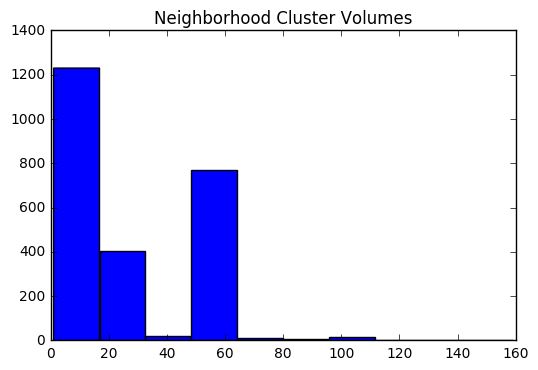

In [22]:
getVolumeHistogram(clustersN, 'Neighborhood Cluster Volumes')

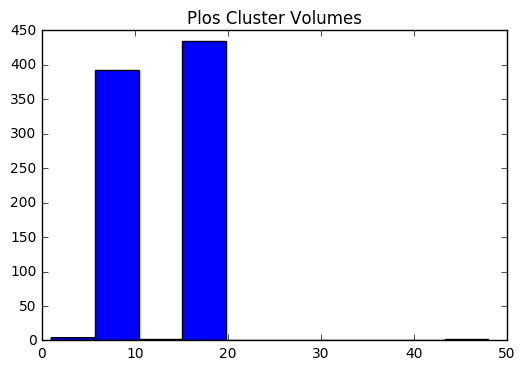

In [24]:
getVolumeHistogram(clustersP, 'Plos Cluster Volumes')

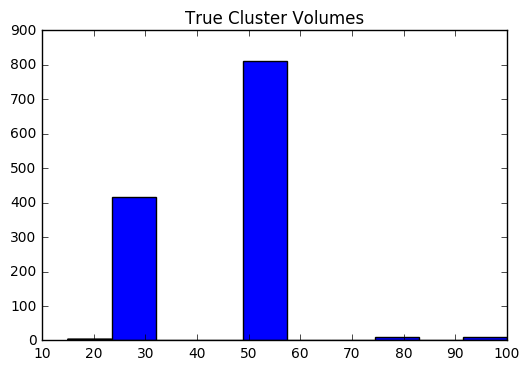

In [25]:
getVolumeHistogram(clustersT, 'True Cluster Volumes')

In [30]:
clustersNT = clusterThresh(realSimNB[4:6], 40)
clustersPT = clusterThresh(realSimPB[4:6], 12)
clustersTT = clusterThresh(testVol[4:6], 40)

In [31]:
precisionN, recallN, f1N, _, _, _ = f1score(clustersTT, clustersNT)
precisionP, recallP, f1P, _, _, _ = f1score(clustersTT, clustersPT)
    
print 'Neighborhood:'
print '\tPrecision: ', precisionN
print '\tRecall: ', recallN
print '\tf1: ', f1N

print 'PLOS:'
print '\tPrecision: ', precisionP
print '\tRecall: ', recallP
print '\tf1: ', f1P

Neighborhood:
	Precision:  1.0
	Recall:  0.978102189781
	f1:  0.988929889299
PLOS:
	Precision:  0.990846681922
	Recall:  0.526763990268
	f1:  0.687847498014
